# Predicting Airline Delay Project
## Part 1: Preparing the Data for Analysis
In this part, we load the entire airline dataset, clean the data and create data visualizations

In [1]:
import pandas as pd
import numpy as np
from os import walk
import time
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
sns.set_style('whitegrid')

In [2]:
tic = time.time()
#Read all the airline data files
df = pd.DataFrame()

f = []
for (dirpath,dirnames,filenames) in walk('airline_data/'):
    f.extend(filenames)
    break

for file in f[1:]:
    df = df.append(pd.read_csv('airline_data/'+file))
    
toc = time.time()
print(toc-tic)

695.0234820842743


## Cleaning up the Data
* Vizualize missing data using seaborn heatmap
* Remove unimportant columns
* Remove CARRIER_DELAY, WEATHER_DELAY, NAS_DELAY, SECURITY_DELAY, LATE_AIRCRAFT_DELAY
* Drop rows which have NaNs in the following fields: UNIQUE_CARRIER, ORIGIN, DEST, CRS_DEP_TIME, CRS_ARR_TIME, ARR_DELAY, CRS_ELAPSED_TIME, DISTANCE

## Prepare the Data
* Get the Departure and Arrival Hour from the Timestamp (0-23)

In [3]:
#Remove columns which are not used in analysis
df.drop(['ORIGIN_STATE_ABR','ORIGIN_AIRPORT_ID','DEST_AIRPORT_ID','DEST_STATE_ABR'],axis=1,inplace=True)
#Delete the categorized delay variables because less than 10% records have these data. Rest are NaNs
df.drop(['Unnamed: 27','CARRIER_DELAY','WEATHER_DELAY','NAS_DELAY','SECURITY_DELAY','LATE_AIRCRAFT_DELAY'],axis=1,inplace=True)

In [4]:
#Drop rows with missing data in the important columns, i.e. the predictors for flight delay
total_data_rows = len(df.index)
#Drop NaNs
df.dropna(subset = ['UNIQUE_CARRIER','ORIGIN','DEST','CRS_DEP_TIME','CRS_ARR_TIME','ARR_DELAY','CRS_ELAPSED_TIME','DISTANCE'],inplace=True)
data_retained = len(df.index)/total_data_rows
print('Data Retained: '+str(round(data_retained*100,2))+' %')

Data Retained: 98.06 %


In [10]:
#Get the Departure and Arrival Hours
#For DEP_HOUR, take the CRS_DEP_TIME
df['DEP_HOUR'] = df['CRS_DEP_TIME'].apply(lambda x:int(str(x)[:2]) if x>999 else int(str(x)[:1] if x>99 else 0))
#For ARR_HOUR, take the actual arrival time
df['ARR_HOUR'] = df['ARR_TIME'].apply(lambda x:int(str(x)[:2]) if x>999 else int(str(x)[:1] if x>99 else 0))
df['ARR_HOUR'] = df['ARR_HOUR'].apply(lambda x:0 if x==24 else x)

In [12]:
#Save the Dataframe as .csv file
tic = time.time()
df.to_csv('Full_airline_data.csv',index=False)
toc = time.time()
print(toc-tic)

461.29819107055664


## Initial Data Exploration

In [13]:
#Total number of flights in our dataset:
len(df.index)

17144203

In [15]:
#Average number of flights per day in 2015:
len(df[df['YEAR']==2015].index)/365

15654.816438356165

In [14]:
#Percent of flights with delays greater than 15 minutes:
len(df[df['ARR_DELAY']>15].index)/len(df.index)

0.18855697170641295

In [16]:
#Head of the data:
df.head()

,YEAR,MONTH,DAY_OF_MONTH,DAY_OF_WEEK,UNIQUE_CARRIER,FL_NUM,ORIGIN,DEST,CRS_DEP_TIME,DEP_TIME,DEP_DELAY,CRS_ARR_TIME,ARR_TIME,ARR_DELAY,CRS_ELAPSED_TIME,ACTUAL_ELAPSED_TIME,AIR_TIME,DISTANCE,DEP_HOUR,ARR_HOUR
0,2013,10,4,5,9E,3283,ATL,OMA,855,855.0,0.0,1025,1021.0,-4.0,150.0,146.0,124.0,821.0,8,10
1,2013,10,26,6,9E,3283,IAH,MSP,730,722.0,-8.0,1021,1018.0,-3.0,171.0,176.0,142.0,1034.0,7,10
2,2013,10,12,6,9E,3283,LGA,CLT,1625,1809.0,104.0,1839,1957.0,78.0,134.0,108.0,81.0,544.0,16,19
3,2013,10,4,5,9E,3283,OMA,ATL,1100,1059.0,-1.0,1409,1415.0,6.0,129.0,136.0,116.0,821.0,11,14
4,2013,10,1,2,9E,3283,TYS,ATL,1708,1702.0,-6.0,1814,1804.0,-10.0,66.0,62.0,32.0,152.0,17,18


## Arrival Delay Visualizations

In [18]:
#Visualize the ARR_DELAYS for top 10 airlines

#Get the list of the 10 biggest Airline Carriers
top10_carrier = list(df['UNIQUE_CARRIER'].value_counts().head(10).index)
df_sub = df[df['UNIQUE_CARRIER'].isin(top10_carrier)][['UNIQUE_CARRIER','ORIGIN','DEST','ARR_DELAY']]

In [20]:
#Read the Carrier Key CSV file for full names of the Airlines
carrier_key = pd.read_csv('L_UNIQUE_CARRIERS.csv')

#Merge with the dataframe containing the 10 biggest Airline Carriers
df_sub = pd.merge(df_sub,carrier_key,how='left',left_on='UNIQUE_CARRIER', right_on='Code')

In [23]:
#Create a copy of the dataframe for Violin plot. Delays greater than 30 minutes are clubbed to show the data at the same scale
df_temp = df_sub.copy()
#All delays greater than 30 minutes are clubbed at 30
df_temp['ARR_DELAY'] = df_temp['ARR_DELAY'].apply(lambda x:30 if x>=30 else x)
df_temp['ARR_DELAY'] = df_temp['ARR_DELAY'].apply(lambda x:-30 if x<=-30 else x)

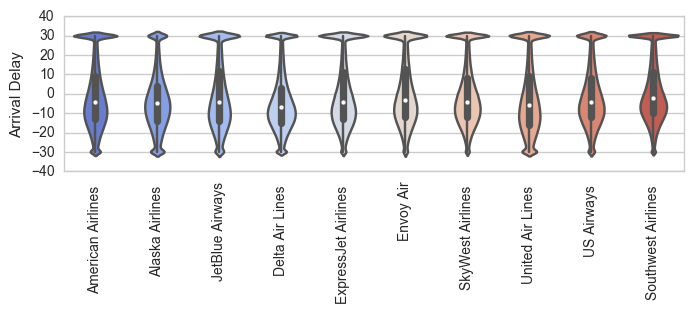

In [24]:
#Create the plot in seaborn
plt.figure(figsize=(8, 2))
g = sns.violinplot(x="Description", y="ARR_DELAY", data=df_temp,palette="coolwarm")
g.set_ylabel('Arrival Delay')
g.set_xlabel('')
label = g.set_xticklabels(g.get_xticklabels(), rotation=90)
fig = g.get_figure()
fig.savefig("delay_violin_plot.png", bbox_inches='tight')

In [119]:
#Plot percentage of flights delayed more than 30 minutes

carrier_delay = pd.DataFrame()

for UC in list(df['UNIQUE_CARRIER'].unique()):
    perc_delayed = len(df[(df['UNIQUE_CARRIER']==UC) & (df['ARR_DELAY']>=30)].index)/len(df[df['UNIQUE_CARRIER']==UC].index)*100
    carrier_delay = carrier_delay.append({'UNIQUE_CARRIER':UC,'percent_delayed' : perc_delayed},ignore_index=True)

carrier_delay = pd.merge(carrier_delay,carrier_key,how='left',left_on='UNIQUE_CARRIER', right_on='Code')
carrier_delay.drop(['UNIQUE_CARRIER','Code'],axis=1,inplace=True)
carrier_delay.rename(index=str,columns={'Description':'Airline'},inplace=True)
#Sort by percentage delayed
carrier_delay.sort_values(by = ['percent_delayed'],ascending=False,inplace=True)

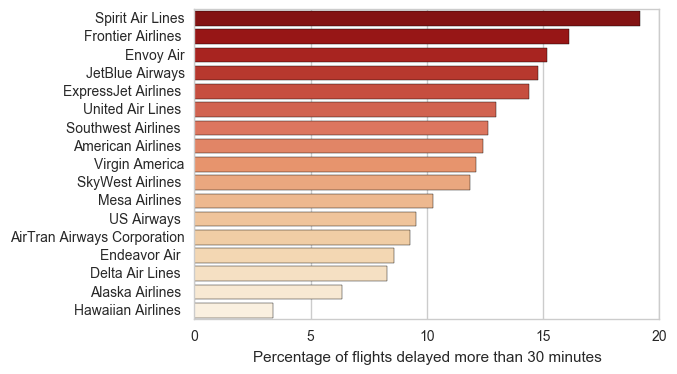

In [95]:
color_pal = sns.color_palette("OrRd", len(carrier_delay.index))
color_pal = color_pal[::-1]

plt.figure(figsize=(6, 4))
g = sns.barplot(x="percent_delayed", y="Airline", data=carrier_delay,palette=abc)
g.set_ylabel('')
g.set_xlabel('Percentage of flights delayed more than 30 minutes')
fig = g.get_figure()
fig.savefig("carrier_delay.png", bbox_inches='tight')

In [121]:
carrier_delay

,percent_delayed,Airline
16,19.156288,Spirit Air Lines
6,16.089775,Frontier Airlines
9,15.180859,Envoy Air
3,14.789599,JetBlue Airways
5,14.383793,ExpressJet Airlines
11,12.959510,United Air Lines
14,12.614928,Southwest Airlines
1,12.395202,American Airlines
13,12.124099,Virgin America
10,11.866243,SkyWest Airlines


In [101]:
del df_temp
del carrier_delay
del df_sub

## Top 50 Airports: Isolating the top 50 Airports by traffic
In this part, we load the entire airline dataset and get a list of the top 50 airports by traffic (Departures + Arrivals). Then we plot the top 50 airports on a map of USA using plotly and cufflinks. 

In [122]:
#Create a new dataframe combining the Arrival and Destination Airports in one column
df_airport = pd.DataFrame(pd.concat([df['ORIGIN'],df['DEST']]),columns={'IATA'})

In [124]:
#Select the Top 50 Airports 
df_top50 = pd.DataFrame(df_airport['IATA'].value_counts().head(50)).reset_index()
df_top50.rename(index=str, columns={"index":"IATA","IATA":"Count"},inplace=True)
del df_airport

To plot the Airports, we import Latitude and Longitude from [OpenFlights.org](http://openflights.org/data.html)

In [125]:
#Read Airport data
df_airports = pd.read_csv('airports.dat')
df_airports = df_airports[df_airports['Country']=='United States'][['IATA','Latitude','Longitude']].copy()

In [126]:
#Merge with the DataFrame containing the list of Top 50 Airports
df_top50 = pd.merge(df_top50,df_airports,how='left',on="IATA")

In [127]:
#Save the top 50 airports in a CSV file
df_top50.to_csv('top50airports.csv',index=False)

## Plotting maps with Plotly

In [128]:
#Map the Airports as a Bubble map, with size corresponding to Traffic
import plotly.plotly as py

#First create a new columns with Textual information
df_top50['text'] = df_top50['IATA'] + '<br>Total Flights: ' + (df_top50['Count']/1e3).astype(str)+' (Thousands)'

#Create plot using Plotly
limits = [(0,10),(11,30),(31,50)]
colors = ["rgb(0,116,217)","rgb(255,65,54)","rgb(133,20,75)"]
names = ["Top 10 Busiest","11-30","31-50"]
cities = []
scale = 2500

for i in range(len(limits)):
    lim = limits[i]
    df_sub = df_top50[lim[0]:lim[1]]
    city = dict(
        type = 'scattergeo',
        locationmode = 'USA-states',
        lon = df_sub['Longitude'],
        lat = df_sub['Latitude'],
        text = df_sub['text'],
        marker = dict(
            size = df_sub['Count']/scale,
            color = colors[i],
            line = dict(width=0.5, color='rgb(40,40,40)'),
            sizemode = 'area'
        ),
        name = names[i] )
    cities.append(city)
    
layout = dict(
        title = 'Top 50 Busiest Airports by Traffic',
        showlegend = True,
        geo = dict(
            scope='usa',
            projection=dict( type='albers usa' ),
            showland = True,
            landcolor = 'rgb(217, 217, 217)',
            subunitwidth=1,
            countrywidth=1,
            subunitcolor="rgb(255, 255, 255)",
            countrycolor="rgb(255, 255, 255)"
        ),
    )

fig = dict( data=cities, layout=layout )
py.iplot( fig, validate=False, filename='d3-map-airports' )

INFO:requests.packages.urllib3.connectionpool:Starting new HTTPS connection (1): api.plot.ly
INFO:requests.packages.urllib3.connectionpool:Starting new HTTPS connection (1): plot.ly


## Plot flight paths of flights with average delay of more than 10 minutes

In [133]:
#Make subset of data containing only flights from top 50 airports
top50_airport = df_top50['IATA'].tolist()
df_sub = df[df['ORIGIN'].isin(top50_airport)]
df_sub = df_sub[df_sub['DEST'].isin(top50_airport)]

In [134]:
#Check the % of data retained:
data_retained = len(df_sub.index)/len(df.index)
print('Data Retained: '+str(round(data_retained*100,2))+' %')

Data Retained: 62.34 %


In [148]:
#Create a dataframe of airports for plotting (top50)
df_airports = pd.DataFrame(df_sub['ORIGIN'].unique())
df_airports.rename(index=str,columns={0:'IATA'},inplace=True)

#Read Airport coordinates
df_airport_coord = pd.read_csv('airports.dat')
df_airport_coord = df_airport_coord[df_airport_coord['Country']=='United States'][['IATA','Latitude','Longitude']].copy()
df_airports = pd.merge(df_airports,df_airport_coord,how='left',on="IATA")

#Read Airport Full Names
airport_key = pd.read_csv('L_AIRPORT.csv')
airport_key.rename(index=str, columns={"Code": "IATA"},inplace=True)
df_airports = pd.merge(df_airports,airport_key,how='left',on='IATA')

In [149]:
#Create a flights dataframe for plotting flight paths
df_flights = df_sub[['ORIGIN','DEST','ARR_DELAY']].groupby(by=['ORIGIN','DEST']).mean()
df_flights.reset_index(inplace=True)
df_flights['ARR_DELAY'] = df_flights['ARR_DELAY'].apply(lambda x:0 if x<0 else round(x))
df_flights.dropna(inplace=True)
#Select only flight paths with average delay of more than 10 minutes
df_flights = df_flights[df_flights['ARR_DELAY']>=10]

In [150]:
#Add start and end latitude and longitude for each flight
df_flights = pd.merge(df_flights,df_airports[['IATA','Latitude','Longitude']],how='left',left_on = 'ORIGIN', right_on = 'IATA')
df_flights.rename(index=str, columns={"Latitude": "start_lat"},inplace=True)
df_flights.rename(index=str, columns={"Longitude": "start_lon"},inplace=True)

df_flights = pd.merge(df_flights,df_airports[['IATA','Latitude','Longitude']],how='left',left_on = 'DEST', right_on = 'IATA')
df_flights.rename(index=str, columns={"Latitude": "end_lat"},inplace=True)
df_flights.rename(index=str, columns={"Longitude": "end_lon"},inplace=True)

df_flights.drop(['IATA_x','IATA_y'],axis=1,inplace=True)

In [151]:
#Remove Honolulu
df_flights = df_flights[df_flights['ORIGIN']!='HNL'].copy()
df_flights = df_flights[df_flights['DEST']!='HNL'].copy()
df_airports = df_airports[df_airports['IATA']!='HNL'].copy()

In [152]:
import plotly.plotly as py

airports = [ dict(
        type = 'scattergeo',
        locationmode = 'USA-states',
        lon = df_airports['Longitude'],
        lat = df_airports['Latitude'],
        hoverinfo = 'text',
        text = df_airports['Description'],
        mode = 'markers',
        marker = dict( 
            size=2, 
            color='rgb(0, 0, 0)',
            line = dict(
                width=3,
                color='rgba(68, 68, 68, 0)'
            )
        ))]
        
flight_paths = []
for i in range( len( df_flights ) ):
    flight_paths.append(
        dict(
            type = 'scattergeo',
            locationmode = 'USA-states',
            lon = [ df_flights['start_lon'][i], df_flights['end_lon'][i] ],
            lat = [ df_flights['start_lat'][i], df_flights['end_lat'][i] ],
            mode = 'lines',
            line = dict(
                #width = 5,
                width = (float((df_flights['ARR_DELAY'][i]-1)-df_flights['ARR_DELAY'].min())/(float(df_flights['ARR_DELAY'].max()-df_flights['ARR_DELAY'].min())/2.0))+2,
                color = 'red'
            ),
            #opacity = 1
            opacity = float(df_flights['ARR_DELAY'][i])/float(df_flights['ARR_DELAY'].max()),
        )
    )
    
layout = dict(
        title = 'Routes with an average delay of more than 10 minutes (2013-2016)',
        showlegend = False, 
        geo = dict(
            scope='usa',
            projection=dict( type='albers usa' ),
            #scope='north america',
            #projection=dict( type='azimuthal equal area' ),
            showland = True,
            landcolor = 'rgb(243, 243, 243)',
            countrycolor = 'rgb(204, 204, 204)',
        ),
    )
    
fig = dict( data=flight_paths + airports, layout=layout )
py.iplot( fig, filename='d3-flight-paths' )


INFO:requests.packages.urllib3.connectionpool:Starting new HTTPS connection (1): plot.ly
